### Numerical Solutions

Solve the 2D elastic wave equation solver with time-domain staggered grid finite difference method (4th order in space, 2nd order in time). All boundaries are simple absorbing boundaries.

The receivers can be set as hydrophones (pressure), geophones (particle velocity) and DAS (avereged strain rate over a guagle length). The calculation of DAS is based on


Eaid, M. V., Keating, S. D., & Innanen, K. A. (2020). Multiparameter seismic 
elastic full-waveform inversion with combined geophone and shaped fiber-optic 
cable data. Geophysics, 85(6), R537-R552.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# Set default font size
plt.rcParams.update({'font.size': 14})

In [7]:
import sys
sys.path.append('../src')
from elasticSolver import elasticSolver, plot_wavefield

In [8]:
# Grid properties
nx, nz = 241, 101       # number of grid points in x and y direction
dx, dz = 10.0, 10.0      # grid spacing in x and y direction
ndamp  = 40              # Damping profile

# Medium properties
vp = np.loadtxt("./Model/Overthrust_501_151_20m.dat")[100:341, :101].reshape(nx, nz)
vs = vp/np.sqrt(3)               # Scale Vs according to the ratio of Vp/Vs
rho = np.power(vp, 0.25) * 310   # Gardner's relation

# Time properties
dt = 0.001               # time step
nt = 1001                # number of time steps

# Source and Receiver properties
f0 = 25.0                # dominant frequency of the source
src_num = 26
geo_num = nx - 20

# load the DAS cable parameters
das_cable = np.loadtxt("../matlab/DAS_cable_par_10.00m.dat")

src_coord = np.array([np.array([dx * 10 + dx * i * 9,   dx])  for i in range(src_num)])
# geo_coord = np.array([np.array([10*dx+i*dx, dx])       for i in range(geo_num)])
geo_coord = das_cable[:,:2]
das_coord = das_cable[:,:2]
das_sensitivity = das_cable[:,3:]
das_num = das_cable.shape[0]

x = np.arange(0, nx * dx, dx)
z = np.arange(0, nz * dz, dz)
t = np.arange(nt)*dt

# set the source time function
stf = (1.0-2.0*np.pi**2*f0**2*(t-1.2/f0)**2)*np.exp(-np.pi**2*f0**2*(t-1.2/f0)**2)
stf = np.pad(stf, (0, nt-len(stf)), 'constant')

# set the source and receiver coordinates
src_grid = np.array([np.round(src_coord[:, 0]/dx).astype(int), np.round(src_coord[:, 1]/dz).astype(int)])
das_grid = np.array([np.round(das_coord[:, 0]/dx).astype(int), np.round(das_coord[:, 1]/dz).astype(int)])
geo_grid = np.array([np.round(geo_coord[:, 0]/dx).astype(int), np.round(geo_coord[:, 1]/dz).astype(int)])

print('Source    : nx = %d - %d, nz = %d - %d'%(src_grid[0,:].min(), src_grid[0,:].max(), src_grid[1,:].min(), src_grid[1,:].max()))
print('DAS cable : nx = %d - %d, nz = %d - %d'%(das_grid[0,:].min(), das_grid[0,:].max(), das_grid[1,:].min(), das_grid[1,:].max()))
print('Geophone  : nx = %d - %d, nz = %d - %d'%(geo_grid[0,:].min(), geo_grid[0,:].max(), geo_grid[1,:].min(), geo_grid[1,:].max()))

Source    : nx = 10 - 235, nz = 1 - 1
DAS cable : nx = 49 - 200, nz = 0 - 75
Geophone  : nx = 49 - 200, nz = 0 - 75


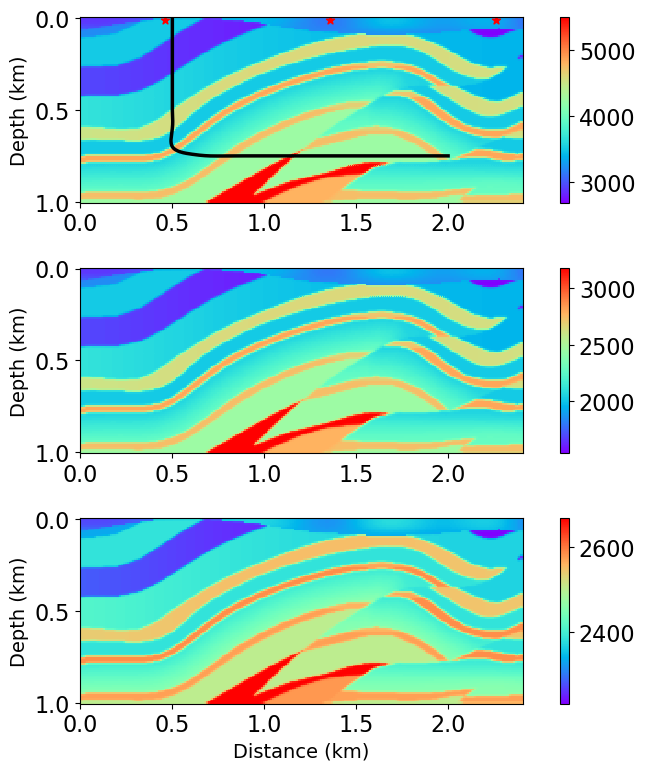

In [21]:
isrc1 = 4
isrc2 = 14
isrc3 = -2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(3, 1, 1)
im = ax.pcolor(x/1000, z/1000, (vp).T, cmap ='rainbow')
plt.plot(das_coord[:,0]/1000, das_coord[:,1]/1000, color='k', linewidth=2.5)
plt.scatter(src_coord[isrc1,0]/1000, src_coord[isrc1,1]/1000, color='r', marker = '*')
plt.scatter(src_coord[isrc2,0]/1000, src_coord[isrc2,1]/1000, color='r', marker = '*')
plt.scatter(src_coord[isrc3,0]/1000, src_coord[isrc3,1]/1000, color='r', marker = '*')

fig.colorbar(im, shrink=1.0)
plt.gca().invert_yaxis()
ax.set_aspect('equal')
plt.ylabel('Depth (km)', fontsize=14)

ax = fig.add_subplot(3, 1, 2)
im = ax.pcolor(x/1000, z/1000, (vs).T, cmap ='rainbow')
fig.colorbar(im, shrink=1.0)
plt.gca().invert_yaxis()
ax.set_aspect('equal')
plt.ylabel('Depth (km)', fontsize=14)

ax = fig.add_subplot(3, 1, 3)
im = ax.pcolor(x/1000, z/1000, (rho).T, cmap ='rainbow')
fig.colorbar(im, shrink=1.0)
plt.gca().invert_yaxis()
ax.set_aspect('equal')
plt.ylabel('Depth (km)', fontsize=14)
plt.xlabel('Distance (km)', fontsize=14)

plt.tight_layout()
plt.savefig('./Fig/Fig-4-model-overthrust.png', dpi=300, bbox_inches='tight')

In [12]:
# set solver
obsSolver = elasticSolver(nx, nz, ndamp, dx, dz, dt, nt, f0, vp, vs, rho, src_coord, das_coord, geo_coord, das_sensitivity)
solu_obs = obsSolver.forward(save_wavefield = True)

In [92]:
# plot the wavefield, vx component, for the 6th source (index=5) 
wavefield_ani = plot_wavefield(solu_obs[5]['vx_wavefield'])
HTML(wavefield_ani.to_jshtml())

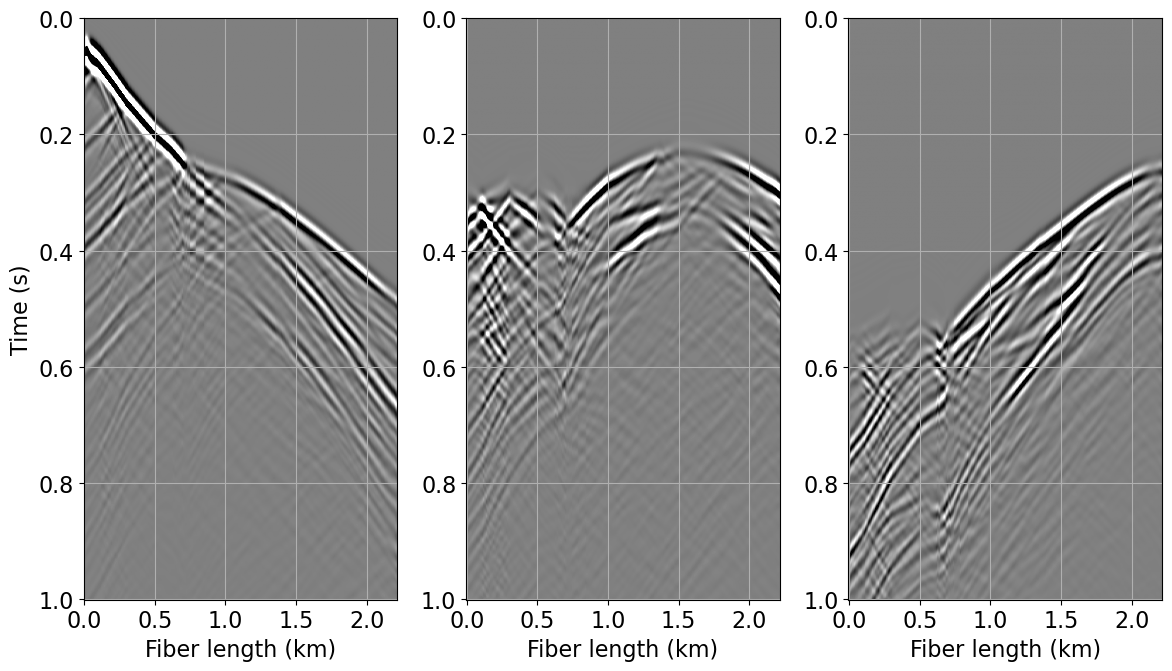

In [23]:

fig = plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(1, 3, 1)
data = solu_obs[isrc1]['ett']
clip = np.percentile(data, 99.)
plt.imshow(data.T, aspect='auto', cmap ='gray', vmin = -clip, vmax =clip)
plt.xticks(np.arange(0, 230, 50), np.arange(0, 230, 50)*dx/1000)
plt.yticks(np.arange(0, 1010, 200), np.arange(0, 1010, 200)*dt)
plt.xlabel('Fiber length (km)', fontsize=16)
plt.ylabel('Time (s)', fontsize=16)
plt.grid()


ax = fig.add_subplot(1, 3, 2)
data = solu_obs[isrc2]['ett']
clip = np.percentile(data, 99.)
plt.imshow(data.T, aspect='auto', cmap ='gray', vmin = -clip, vmax =clip)
plt.xticks(np.arange(0, 230, 50), np.arange(0, 230, 50)*dx/1000)
plt.yticks(np.arange(0, 1010, 200), np.arange(0, 1010, 200)*dt)
plt.xlabel('Fiber length (km)', fontsize=16)
plt.grid()

ax = fig.add_subplot(1, 3, 3)
data = solu_obs[isrc3]['ett']
clip = np.percentile(data, 99.)
plt.imshow(data.T, aspect='auto', cmap ='gray', vmin = -clip, vmax =clip)
plt.xticks(np.arange(0, 230, 50), np.arange(0, 230, 50)*dx/1000)
plt.yticks(np.arange(0, 1010, 200), np.arange(0, 1010, 200)*dt)
plt.xlabel('Fiber length (km)', fontsize=16)
plt.grid()

plt.tight_layout()
plt.savefig('./Fig/Fig-5-waveform-compare.png', dpi=300, bbox_inches='tight')